In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Dropout, Input, Embedding, Bidirectional, Lambda, Conv1D
from keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.utils import to_categorical
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers
from transformers import RobertaTokenizer, TFAutoModel, AdamWeightDecay

In [3]:
# preparin question/class datast to train Siamese Net

dataset = pd.DataFrame(columns=['question', 'class'])
paths = [r'/content/drive/MyDrive/ChatBot/questions/1_3g4G modem.txt',
         r'/content/drive/MyDrive/ChatBot/questions/2_Change of Ownership.txt',
         r'/content/drive/MyDrive/ChatBot/questions/3_Economical Packages.txt',
         r'/content/drive/MyDrive/ChatBot/questions/4_FTTH Service.txt',
         r'/content/drive/MyDrive/ChatBot/questions/5_Participate in auction.txt',
         r'/content/drive/MyDrive/ChatBot/questions/6_Postpaid SIM.txt',
         r'/content/drive/MyDrive/ChatBot/questions/7_Prepaid SIM.txt',
         r'/content/drive/MyDrive/ChatBot/questions/8_TD-LTE modem.txt']

for index, path in enumerate(paths):
    tmp_dataset = pd.read_csv(path, sep='\n\n', header=None, engine='python')
    tmp_dataset.columns = ['question']
    tmp_dataset['class'] = index+1
    dataset = pd.concat([dataset, tmp_dataset], ignore_index=True)

dataset

,question,class
0,What is the customer obligated to do before pu...,1
1,What happens if the customer enters inaccurate...,1
2,What is the customer's responsibility at the t...,1
3,What should the customer avoid doing when rece...,1
4,What does the customer need to provide at the ...,1
...,...,...
1011,"What is required for regular delivery, and how...",8
1012,What valid identity documents are acceptable f...,8
1013,What valid identity document is acceptable for...,8
1014,What actions can the Subscriber take if the po...,8


In [54]:
SEQ_LEN = 40

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [52]:
x_train, x_test, y_train, y_test = train_test_split(
    dataset['question'].values, dataset['class'].values, test_size=0.2, shuffle=True)

In [56]:
def tokenize(df):
    input_ids = []
    attention_masks = []

    for i, text in enumerate(df):
        tokens = tokenizer.encode_plus(text, max_length=SEQ_LEN,
                                       truncation=True, padding='max_length',
                                       add_special_tokens=True, return_attention_mask=True,
                                       return_token_type_ids=False, return_tensors='tf')

        input_ids.append(np.asarray(tokens["input_ids"]).reshape(SEQ_LEN,))
        attention_masks.append(np.asarray(
            tokens["attention_mask"]).reshape(SEQ_LEN,))

    print(len(input_ids), len(attention_masks))
    return (np.asarray(input_ids), np.asarray(attention_masks))


train_input_ids, train_attention_masks = tokenize(x_train)
valid_input_ids, valid_attention_masks = tokenize(x_test)

print(train_input_ids[0])

812 812
204 204
[    0  2264   531    10  2111   109   137  4906    10  7463    12   574
  6433 38533   309     7     5  1286  2788   116     2     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1]


In [57]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [23]:
roberta = TFAutoModel.from_pretrained("roberta-base")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [58]:
input_ids = tf.keras.layers.Input(
    shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(
    shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = roberta(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(128)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Activation("relu")(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(9, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 40)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 40)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 40, 76                                     

In [62]:
optimizer = AdamWeightDecay(
    2e-03, beta_1=0.8, beta_2=0.9, weight_decay_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [63]:
history = model.fit((train_input_ids, train_attention_masks),
                    y_train,
                    validation_data=(
                        (valid_input_ids, valid_attention_masks), y_test),
                    epochs=20,
                    batch_size=32,
                    verbose=2)

Epoch 1/20
26/26 - 29s - loss: 0.5649 - accuracy: 0.7771 - val_loss: 1.7591 - val_accuracy: 0.6127 - 29s/epoch - 1s/step
Epoch 2/20
26/26 - 3s - loss: 0.5215 - accuracy: 0.7919 - val_loss: 2.3974 - val_accuracy: 0.5931 - 3s/epoch - 114ms/step
Epoch 3/20
26/26 - 3s - loss: 0.4698 - accuracy: 0.8239 - val_loss: 1.4890 - val_accuracy: 0.6422 - 3s/epoch - 114ms/step
Epoch 4/20
26/26 - 3s - loss: 0.5060 - accuracy: 0.8042 - val_loss: 1.5933 - val_accuracy: 0.6814 - 3s/epoch - 123ms/step
Epoch 5/20
26/26 - 3s - loss: 0.4567 - accuracy: 0.8116 - val_loss: 1.7120 - val_accuracy: 0.5784 - 3s/epoch - 119ms/step
Epoch 6/20
26/26 - 3s - loss: 0.4782 - accuracy: 0.8128 - val_loss: 1.8138 - val_accuracy: 0.6324 - 3s/epoch - 127ms/step
Epoch 7/20
26/26 - 3s - loss: 0.4453 - accuracy: 0.8374 - val_loss: 1.3525 - val_accuracy: 0.6422 - 3s/epoch - 113ms/step
Epoch 8/20
26/26 - 3s - loss: 0.5483 - accuracy: 0.8251 - val_loss: 1.3690 - val_accuracy: 0.6225 - 3s/epoch - 117ms/step
Epoch 9/20
26/26 - 3s - l

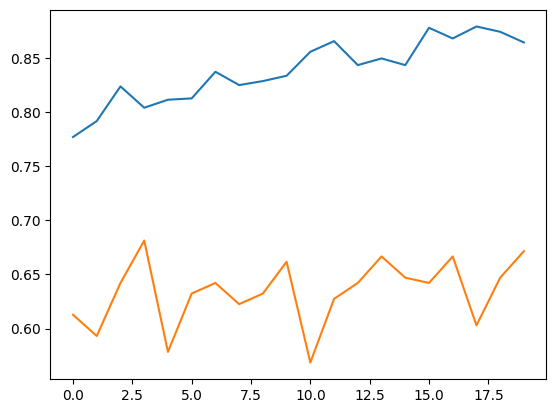

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

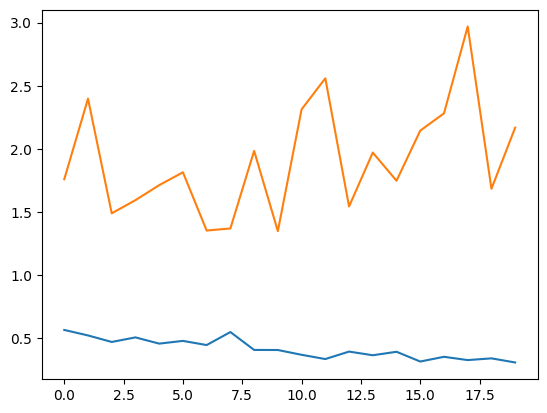

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])